### Load package

In [2]:
import os
import pandas as pd
import numpy as np
import copy
from datetime import datetime
from collections import Counter
from itertools import chain
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Load Data 

In [3]:
Behave = pd.read_csv('data/BehaviorDataForNTU.csv')
Order = pd.read_csv('data/OrderDataForNTU.csv')
Purchase19 = pd.read_csv('data/purchase19.csv')


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (8,9,10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# preprocess date time 
Order['TradesDate'] = Order['TradesDate'].apply(lambda x: datetime.strptime(x,'%Y/%m/%d'))
Behave['HitDateTime'] = Behave['HitDateTime'].apply(lambda x: datetime.strptime(x.split('.')[0], '%Y-%m-%d %H:%M:%S'))
Order['year'] = Order['TradesDate'].apply(lambda x:x.year)
Order['month'] = Order['TradesDate'].apply(lambda x:x.month)

In [5]:
# filter 2018's data which status is Finish
TN = list(Order[(Order['Status']=='Finish') & (Order['year']== 2018) &(Order['month'] <= 12)]['TransactionNum'].unique())
Purchase18 = Behave[(Behave['TransactionNum'].isin(TN))][['VisitorId','HitDateTime']]


### Feature Engineer on 2018 Purchase data

In [6]:
Purchase18.drop_duplicates(subset=['VisitorId','HitDateTime'],inplace= True)
Purchase18['HitYear'] = Purchase18['HitDateTime'].apply(lambda x:x.year)
Purchase18['HitMonth'] = Purchase18['HitDateTime'].apply(lambda x:x.month)  # 只有3-12月
Purchase18['HitDay'] = Purchase18['HitDateTime'].apply(lambda x:x.day)
Purchase18['HitHour'] = Purchase18['HitDateTime'].apply(lambda x:x.hour)



In [7]:
Purchase18 = Purchase18.sort_values(by = ['VisitorId','HitDateTime'])
Purchase18['HitDateTime_shift'] = Purchase18['HitDateTime'].shift(-1)
Purchase18['day_diff'] = Purchase18['HitDateTime_shift'] - Purchase18['HitDateTime']
Purchase18['day_diff'] = Purchase18['day_diff'].dt.days
Purchase18 = Purchase18.reset_index(drop = True)

In [8]:
# extract data that frequency >= 3  
frq = Purchase18.groupby('VisitorId').count()['HitDateTime']
frq = frq[frq >=3 ].to_frame().reset_index()
Purchase18 = Purchase18[Purchase18['VisitorId'].isin(frq['VisitorId'])]
Purchase18 = Purchase18.reset_index(drop = True)

In [9]:
Purchase18

,VisitorId,HitDateTime,HitYear,HitMonth,HitDay,HitHour,HitDateTime_shift,day_diff
0,0022dd08-bb9b-48ef-9c49-49d9d21fe06d,2018-04-24 02:44:44,2018,4,24,2,2018-06-05 00:38:41,41.0
1,0022dd08-bb9b-48ef-9c49-49d9d21fe06d,2018-06-05 00:38:41,2018,6,5,0,2018-06-13 23:21:30,8.0
2,0022dd08-bb9b-48ef-9c49-49d9d21fe06d,2018-06-13 23:21:30,2018,6,13,23,2018-06-27 23:48:56,14.0
3,0022dd08-bb9b-48ef-9c49-49d9d21fe06d,2018-06-27 23:48:56,2018,6,27,23,2018-08-15 13:08:08,48.0
4,0022dd08-bb9b-48ef-9c49-49d9d21fe06d,2018-08-15 13:08:08,2018,8,15,13,2018-04-23 13:31:14,-114.0
...,...,...,...,...,...,...,...,...
12318,ffe88cec-ccb8-4c9e-a708-5dba732fb6d3,2018-08-01 21:19:46,2018,8,1,21,2018-10-30 16:40:53,89.0
12319,ffe88cec-ccb8-4c9e-a708-5dba732fb6d3,2018-10-30 16:40:53,2018,10,30,16,2018-08-17 17:05:45,-74.0
12320,fffb9811-bacf-43e1-ad0e-04e38ace7d28,2018-07-16 22:16:22,2018,7,16,22,2018-07-20 09:53:01,3.0
12321,fffb9811-bacf-43e1-ad0e-04e38ace7d28,2018-07-20 09:53:01,2018,7,20,9,2018-10-03 08:51:16,74.0


### CAI Analysis

CAI is an analysis theory invented by profesosr in National Taiwan University.  
By calculating the value of CAI, we could evaluate customer's active level.  

If there are three user that buying 4 times in 2018, and their transaction time are  
User A: [1/1, 3/1, 5/1, 7/1, 9/1 ]  
User B: [1/1, 6/1, 7/1, 8/1, 9/1 ]  
User C: [1/1, 2/1, 3/1, 4/1, 9/1 ]  

If we user RFM model to analize these three user, we could find out that their recency and frequency are the same  
However, user C is apparently more active because his/her buying happen more recent  


### Thus, we calculate time interval of each buying and give more recent buy a greater weight

In [10]:
Purchase18['weight'] = 0
rowNum = Purchase18.shape[0]
counter = 0
for i in range(rowNum):
    if i != rowNum-1:
        counter+=1
        Purchase18['weight'][i] = counter
        if Purchase18['VisitorId'][i+1] != Purchase18['VisitorId'][i]:
            counter = 0
    else:
        counter+=1
        Purchase18['weight'][i] = counter




/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [11]:
import copy
copy_train = copy.deepcopy(Purchase18)

for i in range(rowNum-1):
    if copy_train['VisitorId'][i]!=copy_train['VisitorId'][i+1]:
        copy_train.drop([i],inplace = True)

copy_train['weighted_day_diff'] = copy_train['day_diff']* copy_train['weight']


In [12]:
summarize = pd.DataFrame()
summarize['avg_day_diff'] = copy_train.groupby('VisitorId').mean()['day_diff']
summarize['avg_weighted_day_diff'] = copy_train.groupby('VisitorId').sum()['weighted_day_diff'] / copy_train.groupby('VisitorId').sum()['weight']
summarize['CAI'] = (summarize['avg_day_diff'] - summarize['avg_weighted_day_diff']) / summarize['avg_day_diff']
summarize = summarize.reset_index()
summarize.fillna(0,inplace = True)



In [13]:
frq18 = (copy_train.groupby('VisitorId').count()['HitDateTime']+1).to_frame().reset_index()
summarize = summarize.merge(frq18,on = 'VisitorId',how = 'left').rename(columns = {'HitDateTime':'frq2018'})
summarize

# print(frq.mean())
# print(frq.max())
# print(frq.min())
# print(frq.std())

,VisitorId,avg_day_diff,avg_weighted_day_diff,CAI,frq2018
0,0022dd08-bb9b-48ef-9c49-49d9d21fe06d,27.750000,29.100000,-0.048649,5
1,0071c6c1-4f81-4e8a-8c6f-f1488c939c0c,15.909091,16.272727,-0.022857,12
2,00df7ee1-72c2-49c3-bb0b-0730e8212374,32.571429,33.892857,-0.040570,8
3,010db26f-a0eb-4383-a0d8-41df1f11cb0a,22.000000,24.333333,-0.106061,4
4,013a6d62-de0c-458f-a837-cf0eb51adbda,76.500000,60.000000,0.215686,3
...,...,...,...,...,...
2478,ff171908-1306-46cd-59d6-95fd57989ced,32.500000,23.333333,0.282051,3
2479,ff6d6b32-66dd-4119-90c9-9d0e57d28118,38.333333,19.833333,0.482609,4
2480,ffe77131-1870-4a07-d860-d7fd3457d873,45.000000,31.000000,0.311111,3
2481,ffe88cec-ccb8-4c9e-a708-5dba732fb6d3,50.000000,63.000000,-0.260000,3


In [14]:
print(summarize['CAI'].mean())
print(summarize['CAI'].max())
print(summarize['CAI'].min())
print(summarize['CAI'].std())

-0.020362694635731277
0.6461748633879781
-0.8571428571428569
0.22368125902964286


### Visualization

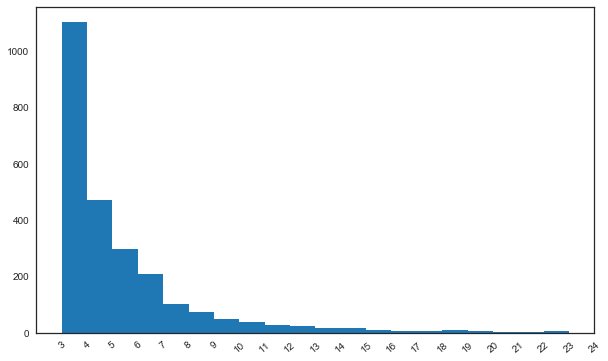

In [15]:
# frequency histogram
plt.style.use('seaborn-white')
plt.figure(figsize = (10,6))

plt.hist(frq['HitDateTime'],bins = np.arange(3,24,1))
plt.xticks(np.arange(3,25,1),rotation = 40)

#plt.savefig('frq_histogram.png',transparent = True)

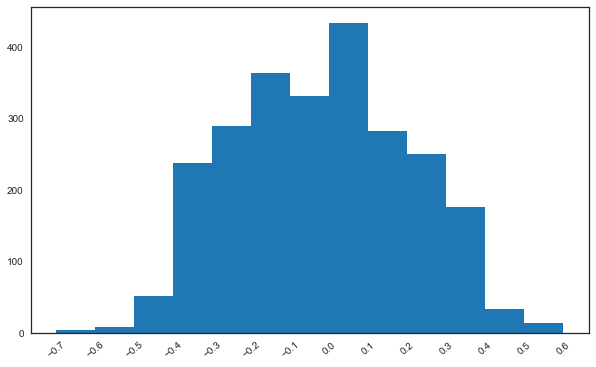

In [20]:
# CAI histogram
'''
CAI > 0 means that the user have greater buying power recently,  
on the contrary, CAI < 0 means that users's frequently get lower
'''
plt.style.use('seaborn-white')
plt.figure(figsize = (10,6))

plt.hist(summarize['CAI'],bins = np.arange(-0.7,0.7,0.1))
plt.xticks(np.arange(-0.7,0.7,0.1),rotation = 40,)

plt.savefig('cai_histogram.png',transparent = True)

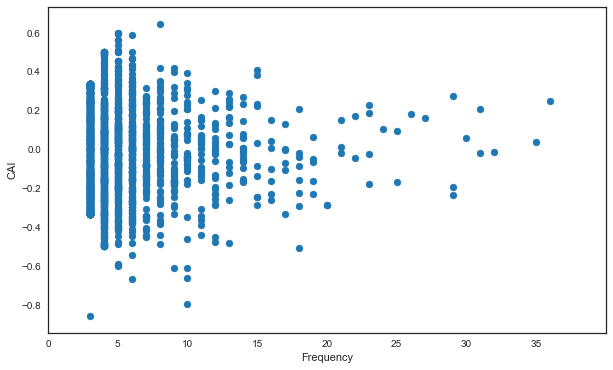

In [21]:
plt.figure(figsize = (10,6))

cai = summarize['CAI']
plt.scatter(frq['HitDateTime'],cai)
plt.xlim(0, 40)
plt.xticks(np.arange(0,40,5))
plt.xlabel('Frequency')
plt.ylabel('CAI')
plt.savefig('scatter_frq_cai.png',transparent = True)

### Hypothesis Validation


Null Hypothesis: CAI and user's loyalty(active level) has positive relatio  
How to validate?  
- Tracking the 2000 active user's transaction in 2019    


In [23]:
Purchase19 = pd.read_csv('data/purchase19.csv')

In [24]:
def process(df):
    df['ht'] = df['ht'].apply(lambda x:datetime.fromtimestamp(int(x) / 1000).strftime('%Y-%m-%d %H:%M:%S'))
    df = df[['did','ht']]
    df = df.rename(columns = {'did':'VisitorId','ht':'HitDateTime'})
    df['HitDateTime'] = df['HitDateTime'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
    df['HitMonth'] = df['HitDateTime'].apply(lambda x:x.month)
    df['HitDay'] = df['HitDateTime'].apply(lambda x:x.day)

    return df

CopyPurchase19 = process(Purchase19)

In [59]:
seg_list = np.array(-1)
seg_list = np.append(seg_list, np.linspace(-0.4,0.4,5))
seg_list = np.append(seg_list,1)
seg_list


array([-1. , -0.4, -0.2,  0. ,  0.2,  0.4,  1. ])

6.930232558139535 0.6417910447761194
6.042168674698795 0.6240601503759399
6.991820040899795 0.6635006784260515
6.914529914529915 0.6473029045643154
6.638376383763838 0.6421800947867299
7.416666666666667 0.72


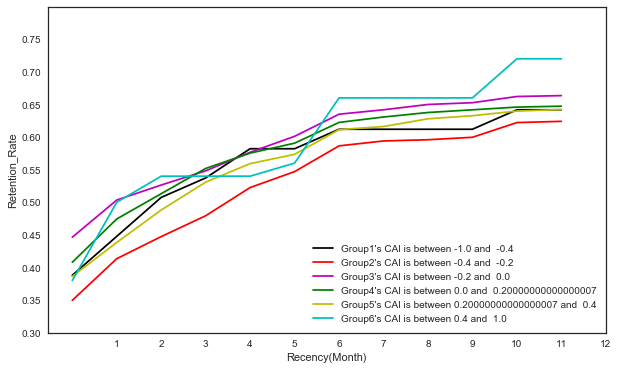

In [62]:
# Segment 24xx users to 4 group according to CAI  
G1 = summarize[summarize['CAI'].between(-0.4,-1)]['VisitorId']
G2 = summarize[summarize['CAI'].between(-0.4,-0.2)]['VisitorId']
G3 = summarize[summarize['CAI'].between(-0.2,0)]['VisitorId']
G4 = summarize[summarize['CAI'].between(0,0.2)]['VisitorId']
G5 = summarize[summarize['CAI'].between(0.2,0.4)]['VisitorId']
G6 = summarize[summarize['CAI'].between(0.4,1)]['VisitorId']

targetID = list(summarize['VisitorId'])
color = ['k','r','m','g','y','c']

plt.figure(figsize=(10,6))
for index in range(len(seg_list)-1):
    GMean = []
    GRet = []
    V_low = seg_list[index]
    V_high = seg_list[index+1]
    G = summarize[summarize['CAI'].between(V_low, V_high)]['VisitorId']
    
    for month in range(1,13):
        tmp = CopyPurchase19
        tmp = tmp[tmp['HitMonth'].between(1,month)]
        tmp = tmp[tmp['VisitorId'].isin(targetID)]
        tmp.drop_duplicates(subset = ['VisitorId','HitDateTime'],inplace= True)
        frq19 = tmp.groupby('VisitorId').count()['HitDateTime'].to_frame().reset_index()

        summarize2 = summarize.merge(frq19,on = 'VisitorId',how = 'left').rename(columns = {'HitDateTime':'frq2019'})
        summarize3 = summarize2[summarize2['frq2019']<100]

        mean = summarize3[summarize3['VisitorId'].isin(G)]['frq2019'].mean()
        ret = summarize3[summarize3['VisitorId'].isin(G)].shape[0]/len(G)
        GMean.append(mean)
        GRet.append(ret)
    plt.plot(GRet,c = color[index],label = f"Group{index+1}'s CAI is between {V_low} and  {V_high}")
    print(mean,ret)
    
plt.xticks(np.arange(1,13,1))
plt.yticks(np.arange(0.3,0.8,0.05))
plt.xlabel('Recency(Month)')
plt.ylabel('Retention_Rate')
plt.ylim(0.3,0.8)
plt.legend()

In [63]:
tmp = CopyPurchase19
tmp = tmp[tmp['HitMonth'].between(1,4)]
tmp = tmp[tmp['VisitorId'].isin(targetID)]
tmp.drop_duplicates(subset = ['VisitorId','HitDateTime'],inplace= True)
frq19 = tmp.groupby('VisitorId').count()['HitDateTime'].to_frame().reset_index()

summarize2 = summarize.merge(frq19,on = 'VisitorId',how = 'left').rename(columns = {'HitDateTime':'frq2019'})
summarize3 = summarize2[summarize2['frq2019']<100]
for index in range(len(seg_list)-1):
    GMean = []
    GRet = []
    V_low = seg_list[index]
    V_high = seg_list[index+1]
    G = summarize[summarize['CAI'].between(V_low, V_high)]['VisitorId']
    
    Num = len(G)
    frq = round(summarize3[summarize3['VisitorId'].isin(G)]['frq2019'].mean(),3)
    ret = round(summarize3[summarize3['VisitorId'].isin(G)].shape[0]/len(G),3)
    print(f'Group {index+1}')
    print(f"Number:{Num} / Avg frequency:{frq} / Retention Rate:{ret}")
    print('\n')

Group 1
Number:67 / Avg frequency:2.972 / Retention Rate:0.537


Group 2
Number:532 / Avg frequency:2.922 / Retention Rate:0.479


Group 3
Number:737 / Avg frequency:3.146 / Retention Rate:0.548


Group 4
Number:723 / Avg frequency:3.13 / Retention Rate:0.552


Group 5
Number:422 / Avg frequency:2.92 / Retention Rate:0.531


Group 6
Number:50 / Avg frequency:2.926 / Retention Rate:0.54




### Wondering Group2's feature

In [64]:
targetTscNum = Behave[(Behave['BehaviorType']=='Purchase') & (Behave['VisitorId'].isin(G2))]['TransactionNum']

In [65]:
SearchBehave = Behave.dropna(subset=['SearchKeyWord'])
G2Search = list(SearchBehave[SearchBehave['VisitorId'].isin(G2)]['SearchKeyWord'])
Allsearch = list(SearchBehave['SearchKeyWord'])

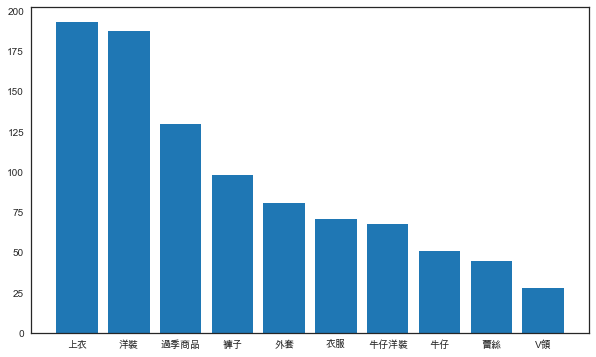

In [66]:
# most frequent search keywork for group2
plt.figure(figsize=(10,6))
y_pos = np.arange(10)
height = dict(Counter(G2Search).most_common(10)).values()
bars = dict(Counter(G2Search).most_common(10)).keys()
plt.bar(y_pos, height)
 
# Create names on the x-axis
plt.xticks(y_pos, bars)
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']

# plt.show() # Show graphic
plt.savefig('G2searchword.jpg')

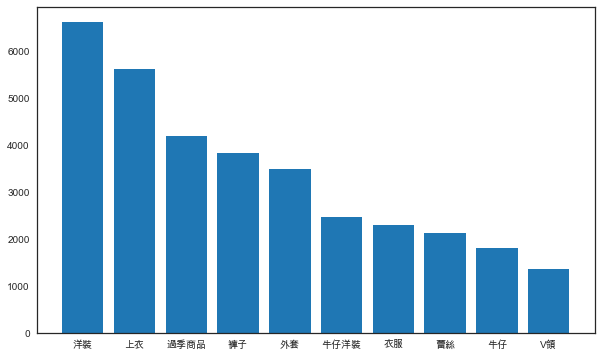

In [67]:
# most frequent search keywork for all group
plt.figure(figsize=(10,6))

y_pos = np.arange(10)
height = dict(Counter(Allsearch).most_common(10)).values()
bars = dict(Counter(Allsearch).most_common(10)).keys()
plt.bar(y_pos, height) # https://python-graph-gallery.com/1-basic-barplot/
 
# Create names on the x-axis
plt.xticks(y_pos, bars)
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS'] # https://blog.csdn.net/qq_32590631/article/details/80509741

# plt.show() # Show graphic
plt.savefig('Allsearchword.jpg')

### Find out the group of High CAI but low frequenct

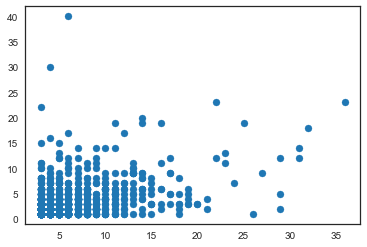

In [49]:
a = summarize[(summarize['CAI'].between(-0.4,0)) & (summarize['frq2018'] > 6)]['VisitorId']
plt.scatter(summarize['frq2018'],summarize2['frq2019'])